# CNN for Image Classification

<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Model</a></li>
    <li><a href="#training">Training</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

import io
import requests

from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

## <a name="data" id="data">Data</a>

Paper: [AniWho: A Quick and Accurate Way to Classify Anime Character Faces in Images](https://arxiv.org/pdf/2208.11012v3). 

The dataset consists of 9,738 images across 130 character classes, with approximately 75 images per class, sourced from the Danbooru website—a platform developed by the Japanese animation-style cartoon community.

For this tutorial, we will use a subset of the dataset. The zip file contains two subfolders: **Anastasia** and **Takao**, each with 50 images.

In [56]:
def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'anastasia': [], 'takao': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['anastasia'].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

In [57]:
# Check the number of images
print("Number of images of Anastasia:", len(images['anastasia']))
print("Number of images of Takao:", len(images['takao']))

Number of images of Anastasia: 50
Number of images of Takao: 50


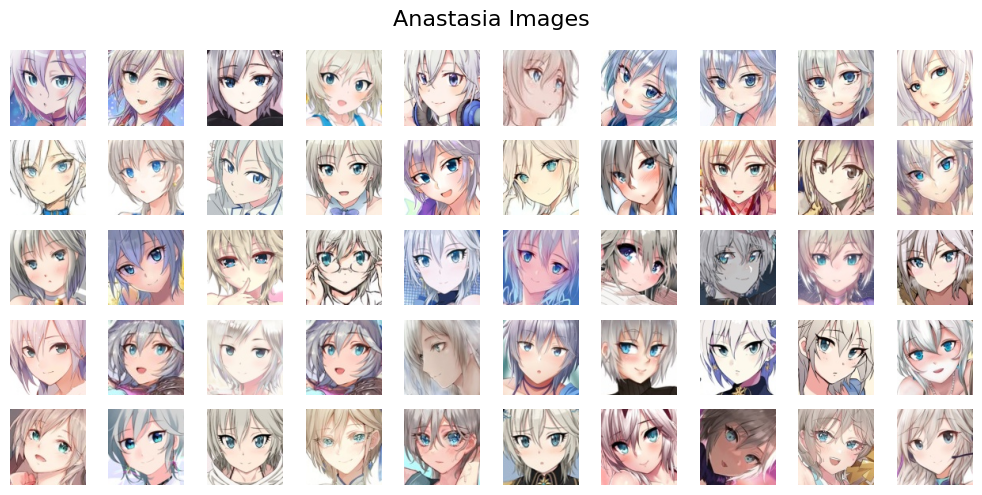

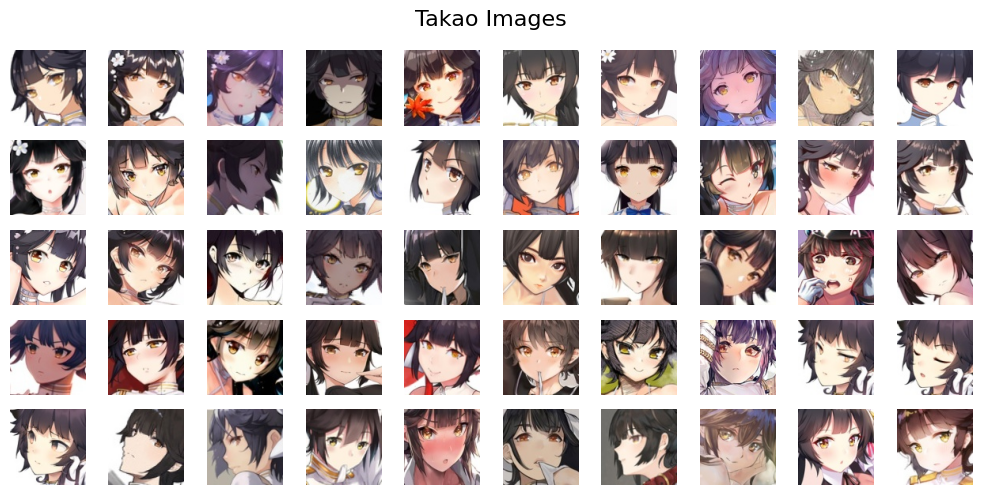

In [58]:
# Visualize data
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from 'anastasia'
plot_images(images['anastasia'], 'Anastasia Images')

# Plot images from 'takao'
plot_images(images['takao'], 'Takao Images')

### Custom dataset

In [59]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes
        
        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])


### Training and Validation sets split

In [60]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 80
Validation size: 20


## <a name="model" id="model">Model</a>

In [ ]:
class AnimeCNN(nn.Module):
    def __init__(self):
        super(AnimeCNN, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = AnimeCNN()

In [62]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [63]:
# Observe tensor shapes per layer
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

# Register hooks
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)

# Inspect output sizes
with torch.no_grad():
    output = model(input_tensor)
print("Final output size:", output.size())

# Remove hooks
for hook in hooks:
    hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


In [64]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## <a name="train" id="train">Train</a>

In [ ]:
# Training loop
num_epochs = 8
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

print('Finished Training')

# Loss should decrease over each iteration

Epoch 1, Train Loss: 0.7333, Validation Loss: 0.1828
Epoch 2, Train Loss: 0.1857, Validation Loss: 0.0011
Epoch 3, Train Loss: 0.0471, Validation Loss: 0.0005
Epoch 4, Train Loss: 0.0086, Validation Loss: 0.0003
Epoch 5, Train Loss: 0.0009, Validation Loss: 0.0002
Epoch 6, Train Loss: 0.0006, Validation Loss: 0.0001
Epoch 7, Train Loss: 0.0003, Validation Loss: 0.0001
Epoch 8, Train Loss: 0.0002, Validation Loss: 0.0001
Finished Training


## <a name="results" id="results">Results</a>

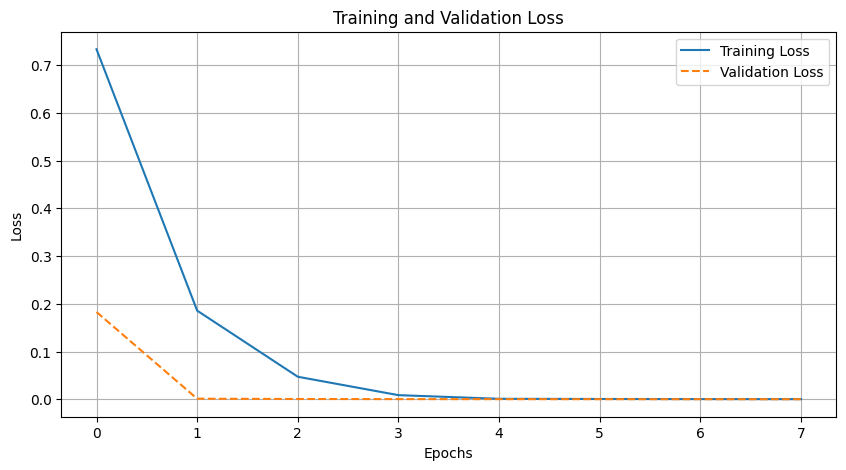

In [66]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


### Evaluate on Validation data

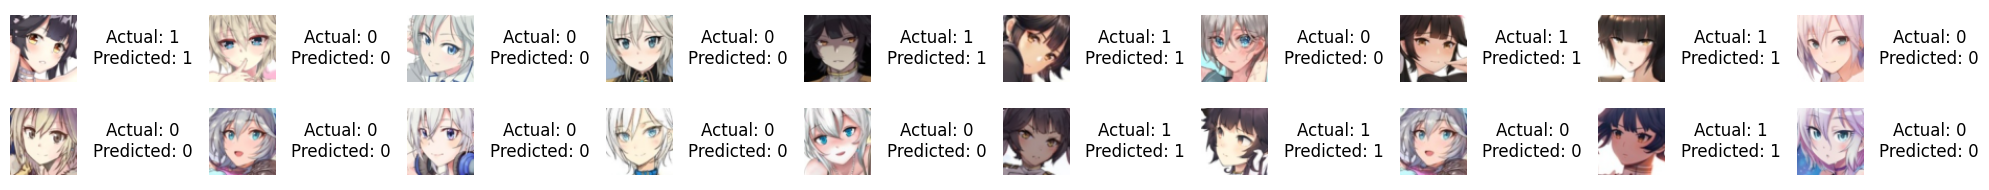

In [67]:
# Display an image
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions to match matplotlib's expected format
    ax.axis('off')

# Set model to evaluation mode
model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    
    # Plot the image
    imshow(images[idx].cpu(), axs[row, col])
    
    # Display actual and predicted labels
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[row, col + 1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [68]:
# Compute metrics
correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    
    for data in val_loader:
        
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'Correct: {correct}, Total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Correct: 20, Total: 20
Validation Accuracy: 100.00%


In [69]:
torch.Tensor.size(data[0])

torch.Size([20, 3, 64, 64])